#  Varational Autoencoder Exercise 

In [2]:
"""x = Input(shape=(original_dim,))
h = Dense(intermediate_dim, activation='relu')(x)
z_mean = Dense(latent_dim)(h)
z_log_var = Dense(latent_dim)(h)"""

"x = Input(shape=(original_dim,))\nh = Dense(intermediate_dim, activation='relu')(x)\nz_mean = Dense(latent_dim)(h)\nz_log_var = Dense(latent_dim)(h)"

In [3]:
"""decoder_h = Dense(intermediate_dim, activation='relu')
decoder_mean = Dense(original_dim, activation='sigmoid')
h_decoded = decoder_h(z)
x_decoded_mean = decoder_mean(h_decoded)"""

"decoder_h = Dense(intermediate_dim, activation='relu')\ndecoder_mean = Dense(original_dim, activation='sigmoid')\nh_decoded = decoder_h(z)\nx_decoded_mean = decoder_mean(h_decoded)"

In [4]:
# https://keras.io/
!pip install -q keras --upgrade
import keras
keras.__version__

Using TensorFlow backend.


'2.1.3'

In [0]:
#import tensorflow as tf

from keras.models import Model,Sequential
from keras.layers import Input, Dense, Lambda, Conv2D, Deconv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Dropout
from keras import backend as K
from keras import metrics
from keras import losses

import seaborn as sns
import pandas as pd

import numpy as np

import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy.stats import norm


In [0]:
from keras.datasets import mnist

In [7]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))

In [0]:
batch_size = 100
original_dim = 784
intermediate_dim = 256
latent_dim = 4
epochs = 200
epsilon_std = 1.0

In [0]:
def sampling(args):
    z_mean, z_log_var = args
    epsilon = K.random_normal(shape=(K.shape(z_mean)[0], latent_dim), mean=0.,
                              stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2) * epsilon

In [0]:
def build_encoder(in_x,network_l,out_z):
  hidden_l = network_l[0][0](in_x)
  hidden_l = network_l[1][0](hidden_l)
  for k in range(1,len(network_l[0])):
    hidden_l = network_l[0][k](hidden_l)
    hidden_l = network_l[1][k](hidden_l)
  z_mean = out_z[0](hidden_l)
  z_log_var = out_z[1](hidden_l)
  z = Lambda(sampling,output_shape=(latent_dim,))([z_mean,z_log_var])  
  return z, z_mean, z_log_var

def build_decoder(in_z,network_l, out_x):
  hidden_l = network_l[0][0](in_z)
  hidden_l = network_l[1][0](hidden_l)
  for k in range(1,len(network_l[0])):
    hidden_l = network_l[0][k](hidden_l)
    hidden_l = network_l[1][k](hidden_l)
  return out_x(hidden_l)

x = Input(shape=(28, 28,1))  # adapt this if using `channels_first` image data format
encoder_conv = []
encoder_pool = []
decoder_conv = []
decoder_pool = []

encoder_conv += [Conv2D(16, (3, 3), activation='relu', padding='same')]
encoder_pool += [MaxPooling2D((2, 2), padding='same')]
encoder_conv += [Conv2D(8, (3, 3), activation='relu', padding='same')]
encoder_pool += [MaxPooling2D((2, 2), padding='same')]
encoder_conv += [Conv2D(8, (3, 3), activation='relu', padding='same')]
encoder_pool += [Flatten()]

z_mean_l = Dense(latent_dim)
z_log_var_l = Dense(latent_dim)

z, z_mean, z_log_var = build_encoder(x,(encoder_conv,encoder_pool),(z_mean_l, z_log_var_l))

decoder_conv += [Dense(units=392,activation='relu')]
decoder_pool += [Reshape((7,7,8,))]
decoder_conv += [Deconv2D(8, (3, 3), activation='relu', padding='same')]
decoder_pool += [UpSampling2D((2, 2))]
decoder_conv += [Deconv2D(16, (3, 3), activation='relu', padding='same')]
decoder_pool += [UpSampling2D((2, 2))]
decoder_out = Deconv2D(1, (3, 3), activation='sigmoid', padding='same')

In [0]:
x_decoded_mean = build_decoder(z,(decoder_conv,decoder_pool), decoder_out) 

#decoder_h = UpSampling2D((2, 2))(decoder_h)
#x_decoded_mean = Deconv2D(16, (3, 3), activation='sigmoid', padding='same')(decoder_h)

In [0]:
VAE = Model(x,x_decoded_mean)


In [13]:
# compute VAE Loss
def vae_loss(x, x_decoded_mean):
    xent_loss = K.sum(original_dim * metrics.binary_crossentropy(x, x_decoded_mean))
    kl_loss = K.sum( - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1))
    vae_loss = xent_loss + kl_loss
    return vae_loss


VAE.compile(optimizer='rmsprop', loss=vae_loss)
VAE.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 28, 28, 1)    0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 28, 28, 16)   160         input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 14, 14, 16)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 14, 14, 8)    1160        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

In [0]:
(x_train,y_train), (x_test,y_test) = mnist.load_data()

x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.

x_train = np.expand_dims(x_train, axis=3)
x_test = np.expand_dims(x_test, axis=3)
#x_train = x_train.reshape(len(x_train), np.prod(x_train.shape[1:])) 
#x_test = x_test.reshape(len(x_test), np.prod(x_test.shape[1:])) 

In [0]:
VAE.fit(x_train, x_train,
        shuffle=True,
        epochs=epochs,
        batch_size=100,
        validation_data=(x_test, x_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/200
60000/60000 [==============================] - 14s 242us/step - loss: 14431706.1383 - val_loss: 12727340.3100
Epoch 2/200
60000/60000 [==============================] - 13s 211us/step - loss: 11797104.3917 - val_loss: 11431348.9500
Epoch 3/200
13300/60000 [=====>........................] - ETA: 9s - loss: 11405510.1955

60000/60000 [==============================] - 13s 209us/step - loss: 11247964.2017 - val_loss: 11053907.6100
Epoch 4/200
60000/60000 [==============================] - 12s 206us/step - loss: 10991421.0333 - val_loss: 10793066.0600
Epoch 5/200
44700/60000 [=====================>........] - ETA: 2s - loss: 10820330.4810

60000/60000 [==============================] - 12s 192us/step - loss: 10811377.2883 - val_loss: 10710134.1200
Epoch 6/200
60000/60000 [==============================] - 12s 199us/step - loss: 10671247.4000 - val_loss: 10696578.5900
Epoch 7/200
52200/60000 [=========================>....] - ETA: 1s - loss: 10554204.6590

60000/60000 [==============================] - 12s 195us/step - loss: 10551411.8083 - val_loss: 10337345.6600
Epoch 8/200
60000/60000 [==============================] - 12s 199us/step - loss: 10450432.2433 - val_loss: 10305564.0800
Epoch 9/200
54100/60000 [==========================>...] - ETA: 1s - loss: 10364583.0684

60000/60000 [==============================] - 12s 200us/step - loss: 10362424.7983 - val_loss: 10368533.1100
Epoch 10/200
60000/60000 [==============================] - 12s 199us/step - loss: 10290520.8717 - val_loss: 10184915.8600
Epoch 11/200
53000/60000 [=========================>....] - ETA: 1s - loss: 10225341.5774

60000/60000 [==============================] - 13s 211us/step - loss: 10226720.5400 - val_loss: 10165370.3000
Epoch 12/200
60000/60000 [==============================] - 12s 208us/step - loss: 10174941.7650 - val_loss: 10113173.0500
Epoch 13/200
52800/60000 [=========================>....] - ETA: 1s - loss: 10130902.8049

60000/60000 [==============================] - 12s 206us/step - loss: 10130918.0150 - val_loss: 10105349.0300
Epoch 14/200
60000/60000 [==============================] - 12s 206us/step - loss: 10088336.3883 - val_loss: 10035829.6500
Epoch 15/200
53000/60000 [=========================>....] - ETA: 1s - loss: 10050317.5094

60000/60000 [==============================] - 12s 199us/step - loss: 10053080.5350 - val_loss: 9932526.7400
Epoch 16/200
60000/60000 [==============================] - 12s 208us/step - loss: 10020558.6283 - val_loss: 9982350.0200
Epoch 17/200
53500/60000 [=========================>....] - ETA: 1s - loss: 9990905.5121

60000/60000 [==============================] - 12s 199us/step - loss: 9990095.1350 - val_loss: 9956806.7200
Epoch 18/200
60000/60000 [==============================] - 12s 198us/step - loss: 9963919.9467 - val_loss: 9894145.1000
Epoch 19/200
55300/60000 [==========================>...] - ETA: 0s - loss: 9943644.4394

60000/60000 [==============================] - 12s 198us/step - loss: 9943215.0200 - val_loss: 9925878.3100
Epoch 20/200
60000/60000 [==============================] - 12s 193us/step - loss: 9922849.1467 - val_loss: 9926382.7300
Epoch 21/200
56200/60000 [===========================>..] - ETA: 0s - loss: 9897724.3470

60000/60000 [==============================] - 12s 202us/step - loss: 9903294.6733 - val_loss: 10000836.5100
Epoch 22/200
60000/60000 [==============================] - 12s 194us/step - loss: 9886374.6800 - val_loss: 10000280.0300
Epoch 23/200
56000/60000 [===========================>..] - ETA: 0s - loss: 9872787.8161

60000/60000 [==============================] - 12s 197us/step - loss: 9872422.1617 - val_loss: 9965064.6300
Epoch 24/200
60000/60000 [==============================] - 11s 189us/step - loss: 9857481.8933 - val_loss: 9818788.2400
Epoch 25/200
60000/60000 [==============================] - 11s 182us/step - loss: 9844009.2100 - val_loss: 9786954.2000
Epoch 26/200
  100/60000 [..............................] - ETA: 11s - loss: 9079805.0000

60000/60000 [==============================] - 11s 190us/step - loss: 9832296.9067 - val_loss: 9743283.1500
Epoch 27/200
60000/60000 [==============================] - 11s 188us/step - loss: 9819987.9867 - val_loss: 9743786.2400
Epoch 28/200
45700/60000 [=====================>........] - ETA: 2s - loss: 9820789.4792

60000/60000 [==============================] - 12s 192us/step - loss: 9809521.2400 - val_loss: 9822002.6800
Epoch 29/200
60000/60000 [==============================] - 12s 199us/step - loss: 9802102.7250 - val_loss: 9843856.4300
Epoch 30/200
53800/60000 [=========================>....] - ETA: 1s - loss: 9796524.3420

60000/60000 [==============================] - 12s 199us/step - loss: 9792369.9017 - val_loss: 9755206.2650
Epoch 31/200
60000/60000 [==============================] - 12s 201us/step - loss: 9782021.2900 - val_loss: 9757974.9300
Epoch 32/200
54900/60000 [==========================>...] - ETA: 0s - loss: 9767018.1967

60000/60000 [==============================] - 12s 200us/step - loss: 9775561.8650 - val_loss: 9776208.2950
Epoch 33/200
60000/60000 [==============================] - 12s 198us/step - loss: 9763794.0083 - val_loss: 10040614.7800
Epoch 34/200
55700/60000 [==========================>...] - ETA: 0s - loss: 9766420.1562

60000/60000 [==============================] - 12s 198us/step - loss: 9759083.2733 - val_loss: 9732794.9650
Epoch 35/200
60000/60000 [==============================] - 12s 193us/step - loss: 9750587.9983 - val_loss: 9800688.1050
Epoch 36/200
56400/60000 [===========================>..] - ETA: 0s - loss: 9745872.9645

60000/60000 [==============================] - 12s 199us/step - loss: 9741682.1633 - val_loss: 9861222.7100
Epoch 37/200
60000/60000 [==============================] - 12s 194us/step - loss: 9734575.4400 - val_loss: 9711207.2500
Epoch 38/200
58600/60000 [============================>.] - ETA: 0s - loss: 9724765.8669

60000/60000 [==============================] - 11s 189us/step - loss: 9726482.2367 - val_loss: 9714414.6100
Epoch 39/200
60000/60000 [==============================] - 12s 199us/step - loss: 9721312.1017 - val_loss: 9935273.2500
Epoch 40/200
58700/60000 [============================>.] - ETA: 0s - loss: 9711585.4719

60000/60000 [==============================] - 11s 191us/step - loss: 9714290.9683 - val_loss: 9720562.4550
Epoch 41/200
60000/60000 [==============================] - 12s 197us/step - loss: 9707168.3500 - val_loss: 9659610.3550
Epoch 42/200
57100/60000 [===========================>..] - ETA: 0s - loss: 9702635.4168

60000/60000 [==============================] - 12s 197us/step - loss: 9702178.5717 - val_loss: 9726130.2850
Epoch 43/200
60000/60000 [==============================] - 12s 196us/step - loss: 9695723.4317 - val_loss: 9681860.9350
Epoch 44/200
55800/60000 [==========================>...] - ETA: 0s - loss: 9695676.5000

60000/60000 [==============================] - 12s 204us/step - loss: 9690614.3450 - val_loss: 9637644.2150
Epoch 45/200
60000/60000 [==============================] - 12s 198us/step - loss: 9683148.4300 - val_loss: 9765749.5500
Epoch 46/200
55900/60000 [==========================>...] - ETA: 0s - loss: 9676123.3882

60000/60000 [==============================] - 12s 200us/step - loss: 9678965.7533 - val_loss: 9619670.6850
Epoch 47/200
60000/60000 [==============================] - 12s 203us/step - loss: 9671730.6417 - val_loss: 9660020.7900
Epoch 48/200
55800/60000 [==========================>...] - ETA: 0s - loss: 9667488.0251

60000/60000 [==============================] - 12s 199us/step - loss: 9668602.1000 - val_loss: 9637764.6200
Epoch 49/200
60000/60000 [==============================] - 12s 204us/step - loss: 9662166.1000 - val_loss: 9816673.1300
Epoch 50/200
56100/60000 [===========================>..] - ETA: 0s - loss: 9667405.2959

60000/60000 [==============================] - 12s 197us/step - loss: 9660302.6800 - val_loss: 9635392.8300
Epoch 51/200
60000/60000 [==============================] - 12s 197us/step - loss: 9653044.9333 - val_loss: 9629460.5900
Epoch 52/200
55800/60000 [==========================>...] - ETA: 0s - loss: 9659750.7473

60000/60000 [==============================] - 12s 198us/step - loss: 9648709.1050 - val_loss: 9703314.6350
Epoch 53/200
60000/60000 [==============================] - 12s 198us/step - loss: 9646011.7600 - val_loss: 9626052.3800
Epoch 54/200
55100/60000 [==========================>...] - ETA: 0s - loss: 9642976.9982

60000/60000 [==============================] - 12s 202us/step - loss: 9639529.2550 - val_loss: 9814337.6000
Epoch 55/200
60000/60000 [==============================] - 12s 194us/step - loss: 9636904.8983 - val_loss: 9622946.2000
Epoch 56/200
55500/60000 [==========================>...] - ETA: 0s - loss: 9633847.1459

60000/60000 [==============================] - 12s 202us/step - loss: 9631633.8200 - val_loss: 9582485.1450
Epoch 57/200
60000/60000 [==============================] - 12s 202us/step - loss: 9628755.7700 - val_loss: 9627253.8050
Epoch 58/200
55500/60000 [==========================>...] - ETA: 0s - loss: 9620580.4685

60000/60000 [==============================] - 12s 201us/step - loss: 9622785.9550 - val_loss: 9669316.6900
Epoch 59/200
60000/60000 [==============================] - 12s 205us/step - loss: 9620757.6400 - val_loss: 9584149.2650
Epoch 60/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9621185.6625

60000/60000 [==============================] - 12s 196us/step - loss: 9618267.8300 - val_loss: 9690856.6350
Epoch 61/200
60000/60000 [==============================] - 12s 204us/step - loss: 9613230.1100 - val_loss: 9616600.8000
Epoch 62/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9610752.5596

60000/60000 [==============================] - 12s 197us/step - loss: 9610535.2467 - val_loss: 9622888.7300
Epoch 63/200
60000/60000 [==============================] - 12s 194us/step - loss: 9606565.6150 - val_loss: 9585595.7450
Epoch 64/200
56300/60000 [===========================>..] - ETA: 0s - loss: 9610084.1190

60000/60000 [==============================] - 12s 197us/step - loss: 9605789.3100 - val_loss: 9583772.9450
Epoch 65/200
60000/60000 [==============================] - 11s 189us/step - loss: 9601677.7417 - val_loss: 9617904.9050
Epoch 66/200
58500/60000 [============================>.] - ETA: 0s - loss: 9596932.4239

60000/60000 [==============================] - 11s 190us/step - loss: 9597002.8300 - val_loss: 9615990.3850
Epoch 67/200
60000/60000 [==============================] - 12s 193us/step - loss: 9593253.8983 - val_loss: 9597590.9550
Epoch 68/200
57700/60000 [===========================>..] - ETA: 0s - loss: 9591804.1828

60000/60000 [==============================] - 12s 193us/step - loss: 9590083.4408 - val_loss: 9607350.9050
Epoch 69/200
60000/60000 [==============================] - 12s 198us/step - loss: 9587947.2850 - val_loss: 9563363.8350
Epoch 70/200
58300/60000 [============================>.] - ETA: 0s - loss: 9589773.9022

60000/60000 [==============================] - 11s 191us/step - loss: 9586104.3867 - val_loss: 9589107.3150
Epoch 71/200
60000/60000 [==============================] - 12s 194us/step - loss: 9583426.4433 - val_loss: 9592563.0800
Epoch 72/200
57300/60000 [===========================>..] - ETA: 0s - loss: 9575933.7190

60000/60000 [==============================] - 12s 197us/step - loss: 9581132.5050 - val_loss: 9630168.6950
Epoch 73/200
60000/60000 [==============================] - 12s 193us/step - loss: 9578832.8733 - val_loss: 9579690.0000
Epoch 74/200
57500/60000 [===========================>..] - ETA: 0s - loss: 9571446.2817

60000/60000 [==============================] - 12s 192us/step - loss: 9576351.6767 - val_loss: 9603786.1850
Epoch 75/200
60000/60000 [==============================] - 12s 194us/step - loss: 9572749.5833 - val_loss: 9627590.0100
Epoch 76/200
59100/60000 [============================>.] - ETA: 0s - loss: 9570230.5161

60000/60000 [==============================] - 11s 187us/step - loss: 9570833.6717 - val_loss: 9587725.9750
Epoch 77/200
60000/60000 [==============================] - 12s 196us/step - loss: 9567441.4467 - val_loss: 9592441.2700
Epoch 78/200
58400/60000 [============================>.] - ETA: 0s - loss: 9569007.3682

60000/60000 [==============================] - 11s 190us/step - loss: 9564873.5483 - val_loss: 9576334.0600
Epoch 79/200
60000/60000 [==============================] - 11s 191us/step - loss: 9565441.0600 - val_loss: 9581365.5700
Epoch 80/200
57800/60000 [===========================>..] - ETA: 0s - loss: 9555176.0640

60000/60000 [==============================] - 12s 200us/step - loss: 9560559.8083 - val_loss: 9518333.5000
Epoch 81/200
60000/60000 [==============================] - 11s 191us/step - loss: 9555082.3317 - val_loss: 9559790.1200
Epoch 82/200
56800/60000 [===========================>..] - ETA: 0s - loss: 9552675.2421

60000/60000 [==============================] - 12s 201us/step - loss: 9558456.1825 - val_loss: 9652143.8250
Epoch 83/200
60000/60000 [==============================] - 12s 200us/step - loss: 9553217.5433 - val_loss: 9624268.4500
Epoch 84/200
55600/60000 [==========================>...] - ETA: 0s - loss: 9543387.0000

60000/60000 [==============================] - 12s 204us/step - loss: 9551777.1633 - val_loss: 9515369.0500
Epoch 85/200
60000/60000 [==============================] - 12s 206us/step - loss: 9550000.6250 - val_loss: 9517309.0150
Epoch 86/200
55100/60000 [==========================>...] - ETA: 0s - loss: 9543867.4955

60000/60000 [==============================] - 12s 203us/step - loss: 9545834.3167 - val_loss: 9557227.0700
Epoch 87/200
60000/60000 [==============================] - 12s 207us/step - loss: 9545250.3700 - val_loss: 9534759.0650
Epoch 88/200
55300/60000 [==========================>...] - ETA: 0s - loss: 9547683.0542

60000/60000 [==============================] - 12s 199us/step - loss: 9540841.2867 - val_loss: 9675949.4600
Epoch 89/200
60000/60000 [==============================] - 12s 202us/step - loss: 9540125.3567 - val_loss: 9632647.7600
Epoch 90/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9539702.1625

60000/60000 [==============================] - 12s 202us/step - loss: 9539634.1833 - val_loss: 9540304.6550
Epoch 91/200
60000/60000 [==============================] - 12s 203us/step - loss: 9536530.8600 - val_loss: 9602561.7150
Epoch 92/200
54500/60000 [==========================>...] - ETA: 1s - loss: 9543780.4862

60000/60000 [==============================] - 12s 204us/step - loss: 9533593.4550 - val_loss: 9501736.8500
Epoch 93/200
60000/60000 [==============================] - 12s 200us/step - loss: 9532343.6842 - val_loss: 9567767.0150
Epoch 94/200
55200/60000 [==========================>...] - ETA: 0s - loss: 9535141.4438

60000/60000 [==============================] - 12s 203us/step - loss: 9530088.4950 - val_loss: 9660107.6850
Epoch 95/200
60000/60000 [==============================] - 12s 200us/step - loss: 9528848.5950 - val_loss: 9496413.6050
Epoch 96/200
55300/60000 [==========================>...] - ETA: 0s - loss: 9524007.4159

60000/60000 [==============================] - 12s 198us/step - loss: 9525620.8650 - val_loss: 9490314.6100
Epoch 97/200
60000/60000 [==============================] - 12s 206us/step - loss: 9524419.6267 - val_loss: 9494229.2650
Epoch 98/200
55700/60000 [==========================>...] - ETA: 0s - loss: 9518888.0916

60000/60000 [==============================] - 12s 196us/step - loss: 9522149.7750 - val_loss: 9539979.9150
Epoch 99/200
60000/60000 [==============================] - 12s 200us/step - loss: 9519733.3317 - val_loss: 9642638.1700
Epoch 100/200
55000/60000 [==========================>...] - ETA: 0s - loss: 9515671.8255

60000/60000 [==============================] - 12s 197us/step - loss: 9516236.6600 - val_loss: 9501677.5900
Epoch 101/200
60000/60000 [==============================] - 12s 192us/step - loss: 9517015.2017 - val_loss: 9596018.4750
Epoch 102/200
55800/60000 [==========================>...] - ETA: 0s - loss: 9513647.7115

60000/60000 [==============================] - 12s 200us/step - loss: 9514053.1917 - val_loss: 9654089.3950
Epoch 103/200
60000/60000 [==============================] - 11s 190us/step - loss: 9510784.8733 - val_loss: 9478379.3700
Epoch 104/200
57000/60000 [===========================>..] - ETA: 0s - loss: 9506789.6860

60000/60000 [==============================] - 12s 194us/step - loss: 9511590.6133 - val_loss: 9491442.2100
Epoch 105/200
60000/60000 [==============================] - 12s 194us/step - loss: 9508480.3100 - val_loss: 9654749.8650
Epoch 106/200
56800/60000 [===========================>..] - ETA: 0s - loss: 9507879.8891

60000/60000 [==============================] - 12s 194us/step - loss: 9506561.9600 - val_loss: 9509230.6600
Epoch 107/200
60000/60000 [==============================] - 12s 205us/step - loss: 9507395.9917 - val_loss: 9500123.3950
Epoch 108/200
54600/60000 [==========================>...] - ETA: 1s - loss: 9502455.2179

60000/60000 [==============================] - 12s 205us/step - loss: 9504710.6333 - val_loss: 9562957.2350
Epoch 109/200
60000/60000 [==============================] - 12s 207us/step - loss: 9502269.6850 - val_loss: 9516978.6050
Epoch 110/200
53900/60000 [=========================>....] - ETA: 1s - loss: 9501600.3098

60000/60000 [==============================] - 12s 204us/step - loss: 9499440.3917 - val_loss: 9550694.6000
Epoch 111/200
60000/60000 [==============================] - 12s 205us/step - loss: 9499274.5150 - val_loss: 9469933.8650
Epoch 112/200
52900/60000 [=========================>....] - ETA: 1s - loss: 9500417.4688

60000/60000 [==============================] - 13s 211us/step - loss: 9496552.7233 - val_loss: 9517046.0800
Epoch 113/200
60000/60000 [==============================] - 12s 201us/step - loss: 9496995.7133 - val_loss: 9503242.2650
Epoch 114/200
54400/60000 [==========================>...] - ETA: 1s - loss: 9486815.4246

60000/60000 [==============================] - 12s 197us/step - loss: 9493966.5717 - val_loss: 9574577.2300
Epoch 115/200
60000/60000 [==============================] - 12s 198us/step - loss: 9492056.3133 - val_loss: 9489513.2650
Epoch 116/200
56000/60000 [===========================>..] - ETA: 0s - loss: 9494036.5643

60000/60000 [==============================] - 12s 194us/step - loss: 9491006.0667 - val_loss: 9502218.4750
Epoch 117/200
60000/60000 [==============================] - 12s 206us/step - loss: 9486950.6375 - val_loss: 9670934.8450
Epoch 118/200
54400/60000 [==========================>...] - ETA: 1s - loss: 9486521.1985

60000/60000 [==============================] - 12s 198us/step - loss: 9487376.2067 - val_loss: 9566975.3800
Epoch 119/200
60000/60000 [==============================] - 12s 200us/step - loss: 9485347.9583 - val_loss: 9509981.0600
Epoch 120/200
54600/60000 [==========================>...] - ETA: 1s - loss: 9481979.6310

60000/60000 [==============================] - 12s 205us/step - loss: 9482623.1508 - val_loss: 9462240.3800
Epoch 121/200
60000/60000 [==============================] - 12s 199us/step - loss: 9484566.2083 - val_loss: 9697237.3000
Epoch 122/200
54500/60000 [==========================>...] - ETA: 1s - loss: 9490413.6312

60000/60000 [==============================] - 12s 205us/step - loss: 9482246.7983 - val_loss: 9473137.7100
Epoch 123/200
60000/60000 [==============================] - 12s 198us/step - loss: 9479473.6750 - val_loss: 9532498.2700
Epoch 124/200
54900/60000 [==========================>...] - ETA: 0s - loss: 9485576.4681

60000/60000 [==============================] - 12s 201us/step - loss: 9478880.7825 - val_loss: 9466410.6050
Epoch 125/200
60000/60000 [==============================] - 12s 198us/step - loss: 9475947.9858 - val_loss: 9470478.7450
Epoch 126/200
56400/60000 [===========================>..] - ETA: 0s - loss: 9471657.7394

60000/60000 [==============================] - 11s 191us/step - loss: 9474498.6225 - val_loss: 9522456.2250
Epoch 127/200
60000/60000 [==============================] - 12s 200us/step - loss: 9473843.0417 - val_loss: 9479948.3600
Epoch 128/200
56900/60000 [===========================>..] - ETA: 0s - loss: 9471499.0228

60000/60000 [==============================] - 11s 189us/step - loss: 9472258.3867 - val_loss: 9523016.1350
Epoch 129/200
60000/60000 [==============================] - 11s 184us/step - loss: 9472961.6558 - val_loss: 9467354.4900
Epoch 130/200
59600/60000 [============================>.] - ETA: 0s - loss: 9467345.7903

60000/60000 [==============================] - 11s 188us/step - loss: 9469003.9150 - val_loss: 9506228.9900
Epoch 131/200
60000/60000 [==============================] - 12s 195us/step - loss: 9471168.0367 - val_loss: 9454884.2450
Epoch 132/200
56700/60000 [===========================>..] - ETA: 0s - loss: 9469703.2046

60000/60000 [==============================] - 12s 202us/step - loss: 9469346.7217 - val_loss: 9500219.6900
Epoch 133/200
60000/60000 [==============================] - 12s 202us/step - loss: 9467603.2600 - val_loss: 9554481.1350
Epoch 134/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9457007.0117

60000/60000 [==============================] - 12s 201us/step - loss: 9465665.3908 - val_loss: 9504617.2250
Epoch 135/200
60000/60000 [==============================] - 12s 202us/step - loss: 9464298.3367 - val_loss: 9458304.1150
Epoch 136/200
55000/60000 [==========================>...] - ETA: 0s - loss: 9461231.0791

60000/60000 [==============================] - 12s 199us/step - loss: 9461586.2308 - val_loss: 9463704.9650
Epoch 137/200
60000/60000 [==============================] - 12s 196us/step - loss: 9461765.6800 - val_loss: 9466323.2100
Epoch 138/200
54900/60000 [==========================>...] - ETA: 0s - loss: 9462443.1403

60000/60000 [==============================] - 12s 200us/step - loss: 9459424.1417 - val_loss: 9486009.8400
Epoch 139/200
60000/60000 [==============================] - 12s 196us/step - loss: 9459441.4750 - val_loss: 9492932.9450
Epoch 140/200
55100/60000 [==========================>...] - ETA: 0s - loss: 9455698.8730

60000/60000 [==============================] - 12s 202us/step - loss: 9458266.7617 - val_loss: 9472661.9900
Epoch 141/200
60000/60000 [==============================] - 12s 199us/step - loss: 9459002.3667 - val_loss: 9529687.5450
Epoch 142/200
54900/60000 [==========================>...] - ETA: 0s - loss: 9452198.1357

60000/60000 [==============================] - 12s 203us/step - loss: 9455550.0575 - val_loss: 9470492.1000
Epoch 143/200
60000/60000 [==============================] - 12s 200us/step - loss: 9455368.0408 - val_loss: 9464783.7600
Epoch 144/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9449561.1769

60000/60000 [==============================] - 12s 200us/step - loss: 9452649.0800 - val_loss: 9495498.9500
Epoch 145/200
60000/60000 [==============================] - 12s 202us/step - loss: 9450253.4050 - val_loss: 9468063.1400
Epoch 146/200
55000/60000 [==========================>...] - ETA: 0s - loss: 9446702.8100

60000/60000 [==============================] - 12s 200us/step - loss: 9450990.6692 - val_loss: 9517865.5000
Epoch 147/200
60000/60000 [==============================] - 12s 202us/step - loss: 9446987.4783 - val_loss: 9505302.5900
Epoch 148/200
55300/60000 [==========================>...] - ETA: 0s - loss: 9448237.0127

60000/60000 [==============================] - 12s 199us/step - loss: 9449713.1267 - val_loss: 9444565.0200
Epoch 149/200
60000/60000 [==============================] - 12s 202us/step - loss: 9446566.3558 - val_loss: 9477929.0100
Epoch 150/200
51800/60000 [========================>.....] - ETA: 1s - loss: 9447908.0907

60000/60000 [==============================] - 13s 221us/step - loss: 9445961.1133 - val_loss: 9470534.2850
Epoch 151/200
60000/60000 [==============================] - 12s 205us/step - loss: 9446117.9467 - val_loss: 9512267.1100
Epoch 152/200
54500/60000 [==========================>...] - ETA: 1s - loss: 9439996.3073

60000/60000 [==============================] - 12s 196us/step - loss: 9443280.0992 - val_loss: 9460321.3850
Epoch 153/200
60000/60000 [==============================] - 11s 191us/step - loss: 9442761.8375 - val_loss: 9476634.7100
Epoch 154/200
56900/60000 [===========================>..] - ETA: 0s - loss: 9446863.4517

60000/60000 [==============================] - 12s 192us/step - loss: 9444328.9067 - val_loss: 9655404.1650
Epoch 155/200
60000/60000 [==============================] - 12s 198us/step - loss: 9440845.1583 - val_loss: 9442342.5700
Epoch 156/200
56100/60000 [===========================>..] - ETA: 0s - loss: 9440927.3815

60000/60000 [==============================] - 12s 196us/step - loss: 9440481.3650 - val_loss: 9426281.2550
Epoch 157/200
60000/60000 [==============================] - 12s 201us/step - loss: 9439034.2817 - val_loss: 9434391.4700
Epoch 158/200
55900/60000 [==========================>...] - ETA: 0s - loss: 9440822.3238

60000/60000 [==============================] - 12s 196us/step - loss: 9438924.1750 - val_loss: 9494800.1600
Epoch 159/200
60000/60000 [==============================] - 12s 194us/step - loss: 9438025.7775 - val_loss: 9485665.3550
Epoch 160/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9439414.9386

60000/60000 [==============================] - 12s 202us/step - loss: 9438232.1133 - val_loss: 9547772.5750
Epoch 161/200
60000/60000 [==============================] - 12s 196us/step - loss: 9435770.5367 - val_loss: 9412877.9800
Epoch 162/200
55400/60000 [==========================>...] - ETA: 0s - loss: 9426695.5289

60000/60000 [==============================] - 12s 200us/step - loss: 9433358.5317 - val_loss: 9512859.6000
Epoch 163/200
60000/60000 [==============================] - 12s 198us/step - loss: 9436047.9017 - val_loss: 9475917.2850
Epoch 164/200
56200/60000 [===========================>..] - ETA: 0s - loss: 9432863.3132

60000/60000 [==============================] - 12s 194us/step - loss: 9433998.1550 - val_loss: 9428409.1850
Epoch 165/200
60000/60000 [==============================] - 13s 209us/step - loss: 9431559.8967 - val_loss: 9473874.5050
Epoch 166/200
54700/60000 [==========================>...] - ETA: 1s - loss: 9434381.2614

60000/60000 [==============================] - 12s 203us/step - loss: 9431143.3350 - val_loss: 9426523.9400
Epoch 167/200
60000/60000 [==============================] - 12s 205us/step - loss: 9432358.2067 - val_loss: 9469654.6250
Epoch 168/200
55100/60000 [==========================>...] - ETA: 0s - loss: 9435095.9265

60000/60000 [==============================] - 12s 197us/step - loss: 9429853.4850 - val_loss: 9523577.7700
Epoch 169/200
60000/60000 [==============================] - 12s 197us/step - loss: 9427830.9750 - val_loss: 9452445.3750
Epoch 170/200
54500/60000 [==========================>...] - ETA: 1s - loss: 9436660.8642

60000/60000 [==============================] - 12s 204us/step - loss: 9426427.7167 - val_loss: 9442146.0600
Epoch 171/200
60000/60000 [==============================] - 12s 205us/step - loss: 9426867.1308 - val_loss: 9451640.1100
Epoch 172/200
35200/60000 [================>.............] - ETA: 4s - loss: 9428473.2528

In [0]:
encoder = Model(x, z_mean)

x_test_encoded = encoder.predict(x_test, batch_size=batch_size)
#plt.figure(figsize=(6, 6))
#plt.scatter(x_test_encoded[:, 0], x_test_encoded[:, 1], x_test_encoded[:, 2], c=y_test, cmap=cm.jet)
#plt.colorbar()
#plt.show()

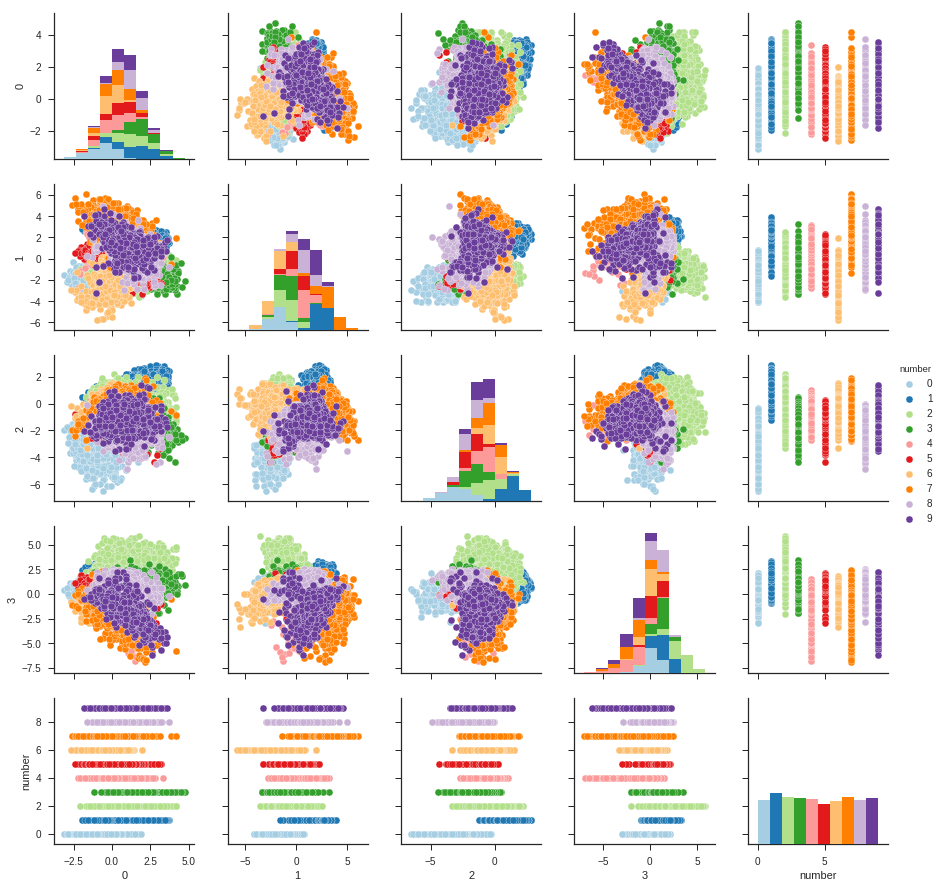

In [0]:
sns.set(style="ticks")

df = pd.DataFrame(x_test_encoded)
df['number'] = y_test

sns.pairplot(df, hue="number",palette="Paired")

In [0]:
#decoder_input = Input(shape=(latent_dim,))
#_h_decoded = decoder_h(decoder_input)
#_x_decoded_mean = decoder_mean(_h_decoded)
#generator = Model(decoder_input, _x_decoded_mean)

In [0]:
generator_input = Input(shape=(latent_dim,))
generator_output = build_decoder(generator_input,(decoder_conv,decoder_pool), decoder_out)
generator = Model(generator_input,generator_output) 

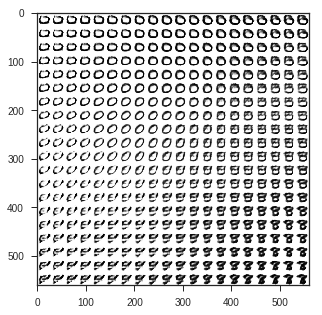

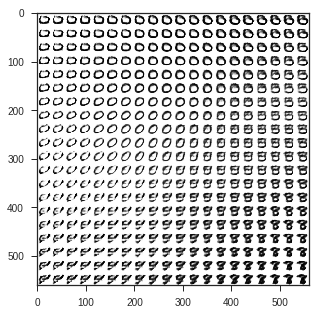

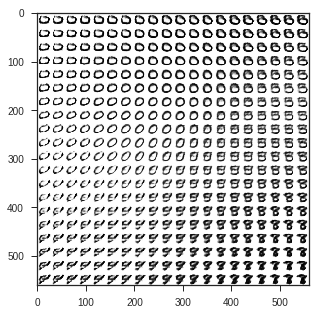

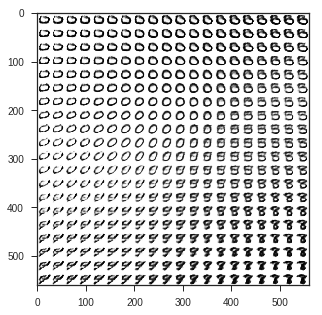

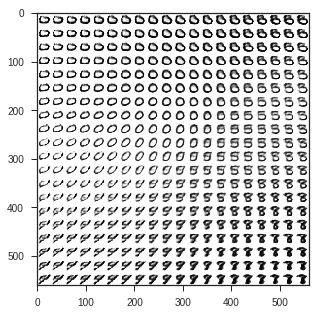

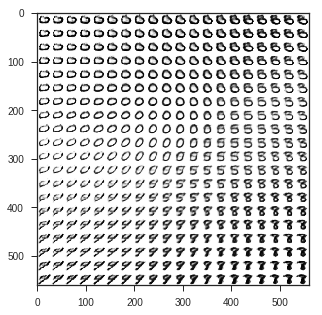

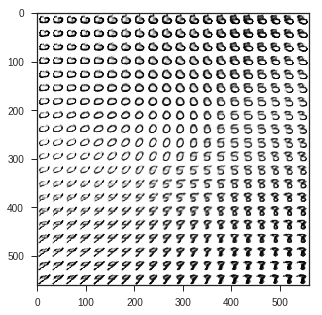

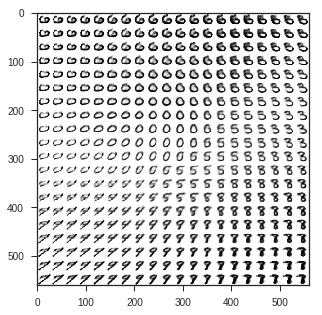

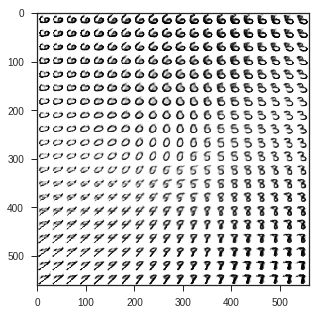

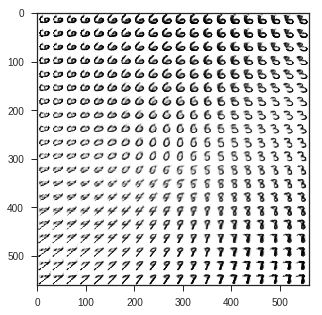

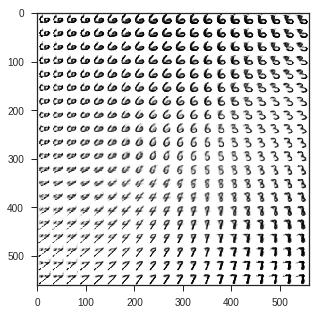

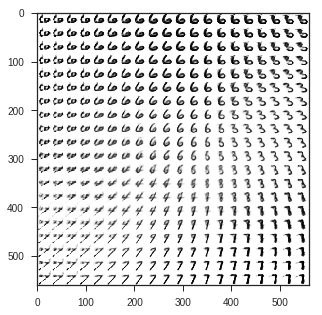

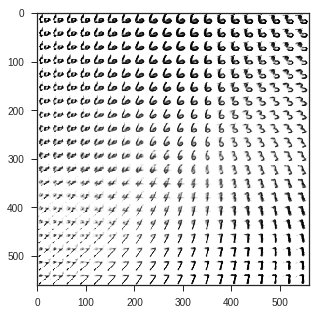

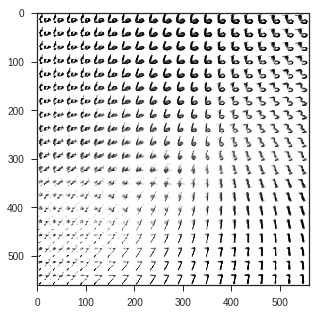

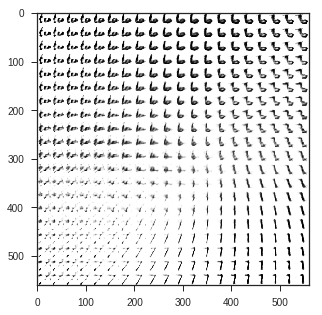

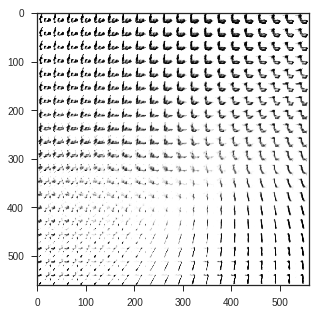

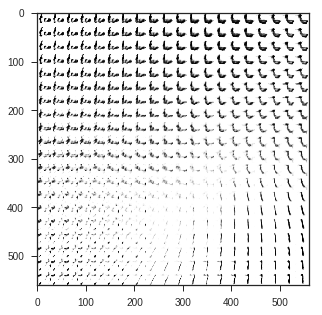

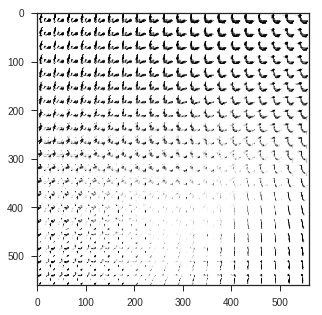

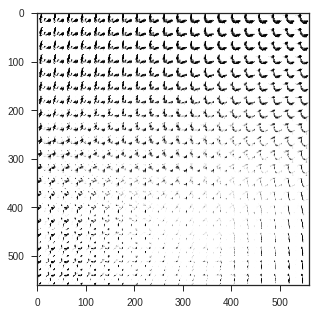

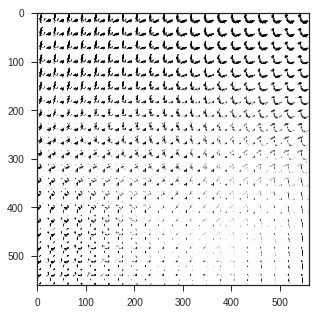

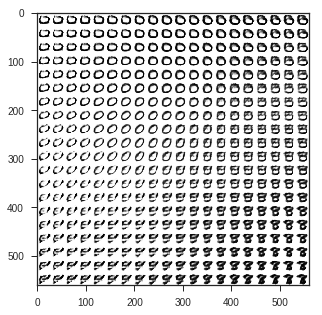

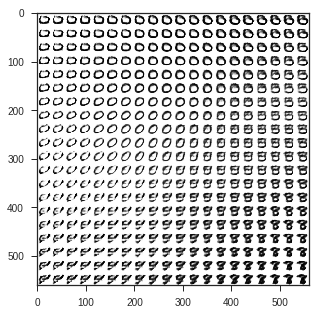

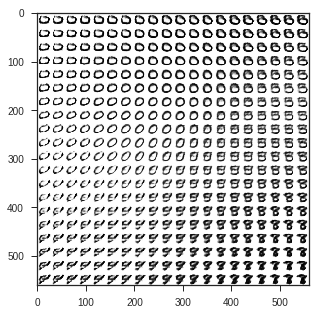

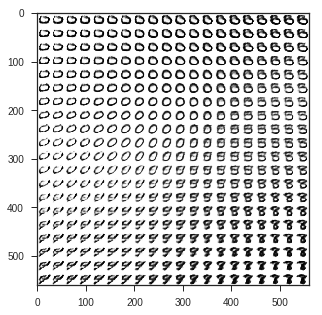

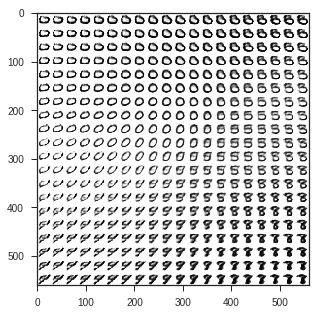

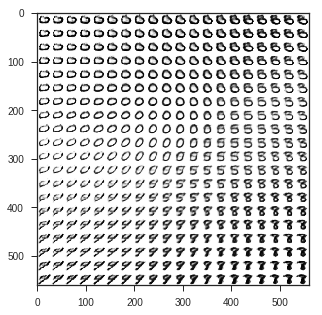

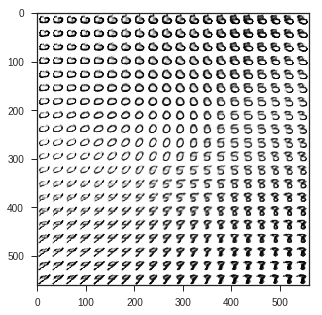

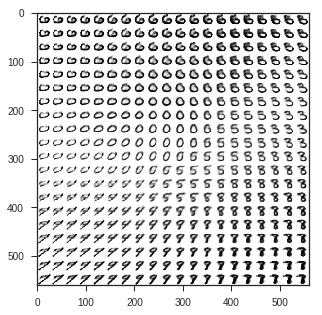

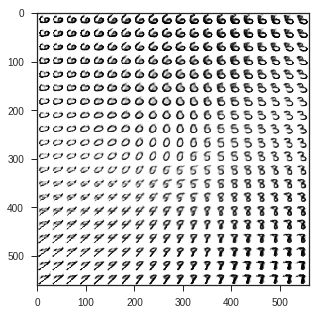

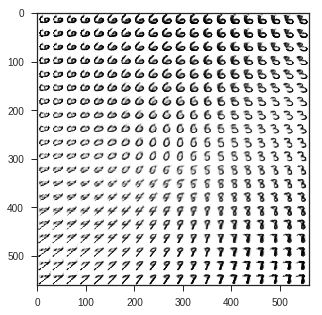

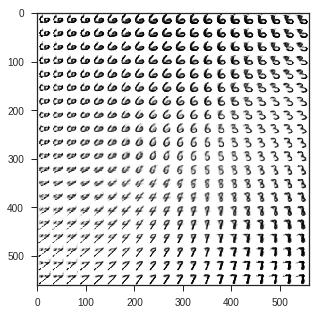

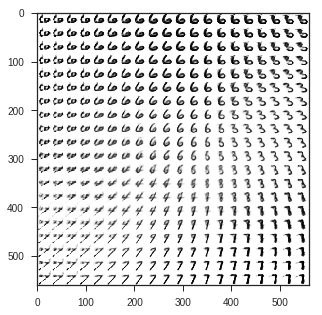

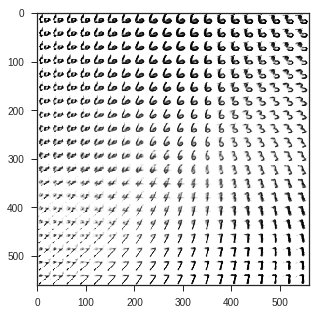

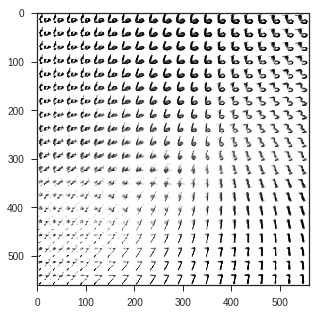

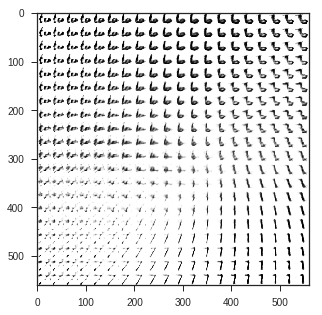

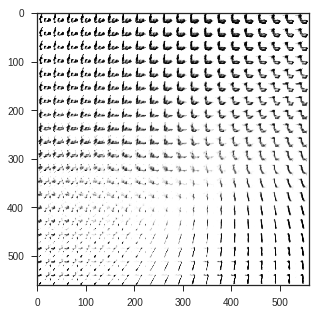

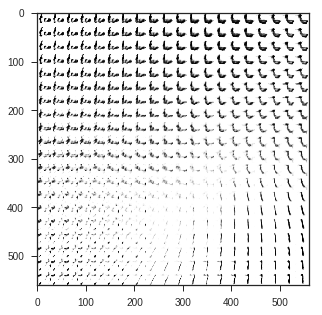

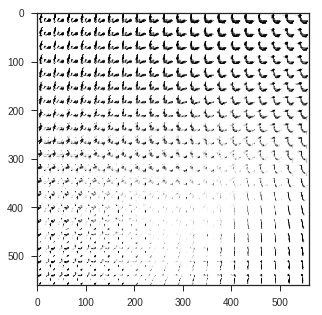

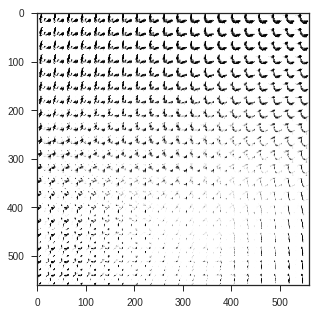

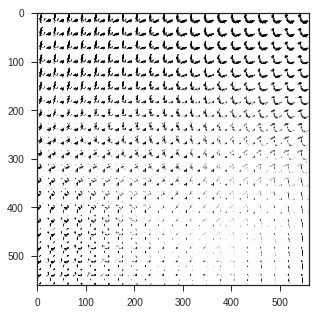

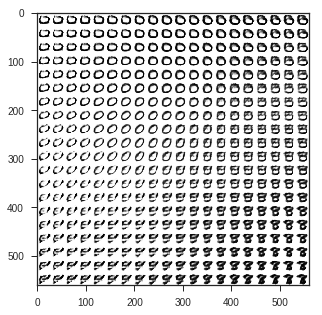

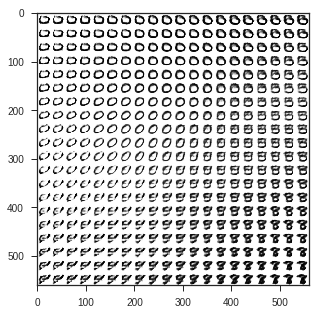

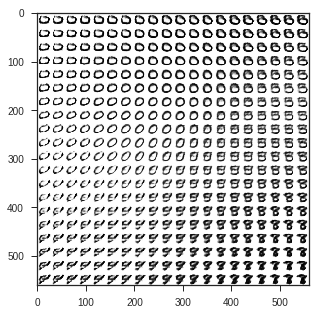

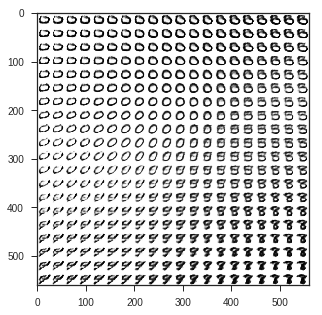

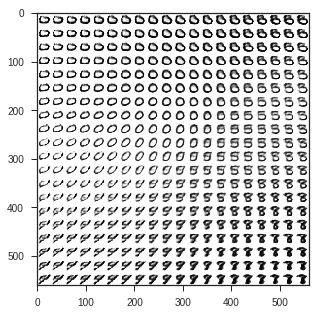

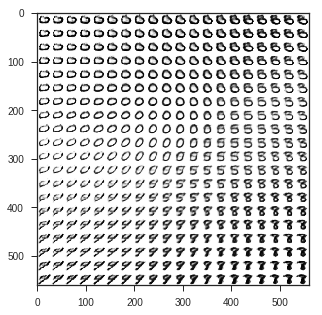

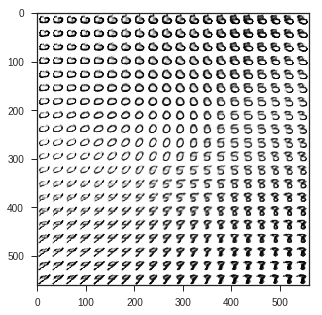

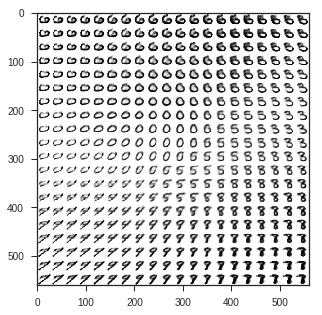

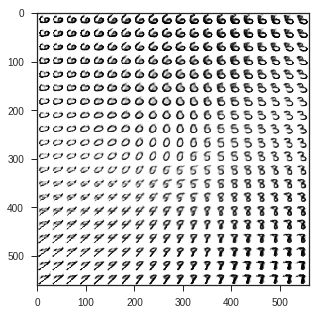

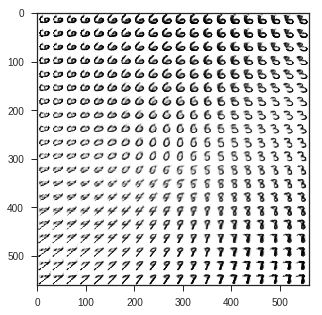

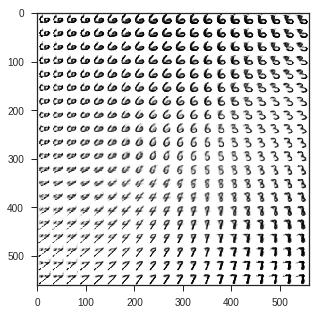

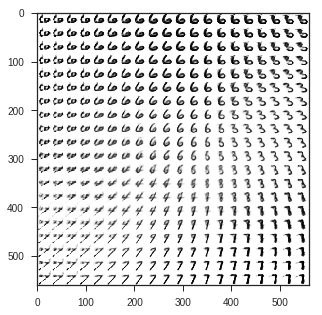

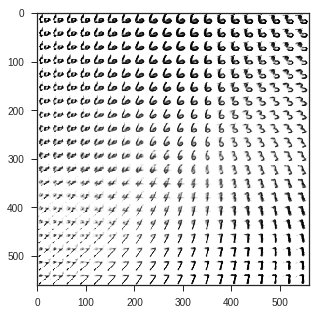

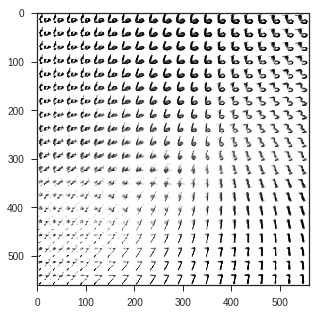

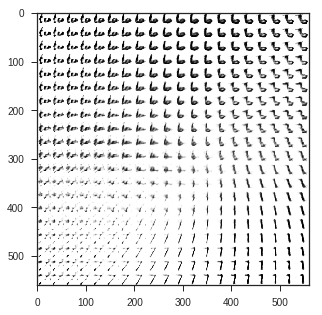

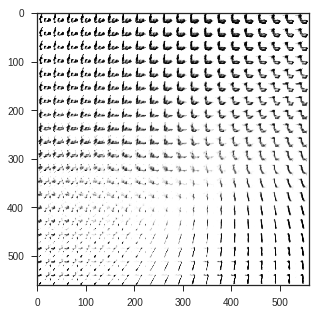

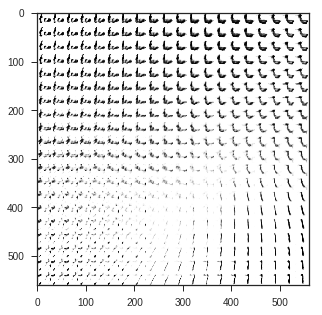

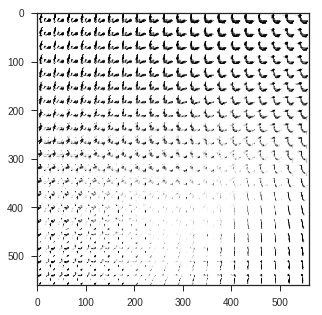

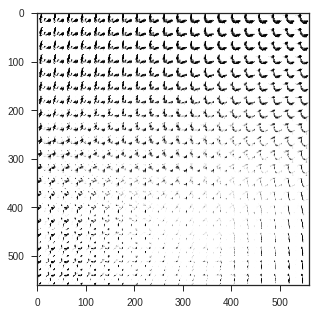

Your cell size is close to the size limit (9M). Large new outputs may be dropped. So far, 51.3M of output have been discarded. 

In [0]:
n = 20  # figure with 15x15 digits
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))
# we will sample n points within [-15, 15] standard deviations
grid_x = np.linspace(-6, 4, n)
grid_y = np.linspace(-4, 4, n)
grid_z = np.linspace(-6, 4, n)
grid_w = np.linspace(-6, 4, n)
#for n, wi in enumerate(grid_w):
for k, zi in enumerate(grid_z):
  for i, yi in enumerate(grid_x):
    for j, xi in enumerate(grid_y):
        z_sample = np.array([[xi, yi, zi, 0]]) * epsilon_std
        x_decoded = np.squeeze(generator.predict(z_sample))
        digit = x_decoded #[0].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
               j * digit_size: (j + 1) * digit_size] = digit

  #fig, axs = plt.subplots(nrows=n, ncols=n,figsize=(10, 10))
  plt.figure(figsize=(5,5))
  plt.imshow(figure, cmap=cm.gray_r)
  plt.show()

In [0]:
hot1 = Input(shape=(10,))
input_encoder = []
input_drop = []
input_encoder.append( Dense(50, activation='relu'))
input_encoder.append( Dense(latent_dim, activation='relu'))
input_drop.append(Dropout(.3))

for i in range(len(decoder_conv)):
  decoder_conv[i].trainable = False
  decoder_pool[i].trainable = False

decoder_out.trainable = False

keyboard_listener = input_encoder[0](hot1)
keyboard_listener = input_drop[0](keyboard_listener)
keyboard_listener = input_encoder[1](keyboard_listener)

input_converter = build_decoder(keyboard_listener,(decoder_conv,decoder_pool), decoder_out)

full_model = Model(hot1,input_converter)
full_model.compile((optimizer='rmsprop',loss=metrics.binary_crossentropy(x_train, x_decoded_mean))

In [0]:
full_model.fit(pd.get_dummies(y_train), x_train,
               shuffle=True,
               epochs=epochs,
               batch_size=100,
               validation_data=(pd.get_dummies(y_test), x_test))